<h2>Data Analysis and Classification of Whether a New Client Will Subscribe to a Term Deposit.</h2>

DSCI 100 Final Project Notebook (Group Members 25: Armaan Kara, Daniel Lee, Leo Ng, Maddie Buss)

In [62]:
# SETUP CODE
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
install.packages("pastecs")
library(pastecs)
options(repr.matrix.max.rows = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



<h2>1) Introduction</h2>

Bank managers have been asking the same question for a long time. What sort of clients will subscribe to a term deposit? To solve this question, we have downloaded the “bank-additional-full.csv” data set from the Portuguese banking institution to analyze the results and conduct the research. By using the KNN classification method, we aim to predict if the client will subscribe to a term deposit or not. 

"Bank-additional-full.csv” is a document representing the marketing efforts of the Portuguese banking institution. 21 variables are measured, with the classification variable being whether or not a client will subscribe to a term deposit. A term deposit is a fixed-term investment that contains the deposit of funds into an account at a financial institution and receives a certain amount of interest on the maturity date **(insert Reference here https://www.investopedia.com/terms/t/termdeposit.asp)**. This data was originally produced by researchers at the University Institute of Lisbon for a report highlighting a data-driven approach to predict the successfulness of bank telemarketing.

This dataset features 20 attributes regarding demographics (age, job, marital status), economic and educational situation (level of education, possession of a housing loan), and historical information’s relationship to the banking institution (last month of contact, outcome from previous marketing campaign). In order to make this prediction more effective and accurate, we have filtered out the 4 most important predictors after analysing the data correlation between the variables, and using these 4 variables as our predictor to conduct KNN classification analysis, and each of the variables contains 41188 observations, which makes the whole prediction more trustworthy and accurate. We will separate 75% of the data into the training set and 25% of the remaining into the testing set in order to find out the most suitable k-neighbour in our function, and also solving the problem of class imbalance. After identifying the correct "k" for the function, we will use "ggpairs" to create a visual comparison to demonstrate the correlation between each variable measured, and at last, come up with an accurate and effective prediction. 

Our project will be able to answer the question; given a new client (a new row in the table), will the client subscribe to a term deposit or not? 

<h2>2a) Exploratory Data Analysis</h2>
The Bank Marketing data set contains roughly 45,000 observations and can be found on the UCI Machine Learning Repository under the Data Folder.

In [63]:
# Retrieving and preparing the dataset for classification
library(GGally)
# Set the seed to improve reproducibilty for generating random numbers
set.seed(7134) 
# Creating a temporary file to mitigate the creation of an unreadable file due to a compressed download
temp <- tempfile()

# Read the dataset and discard the unnecessary columns. It is labelled as bank_data
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip",temp)
bank_data <- read.table(unz(temp, "bank-full.csv"), sep=";", header=TRUE)
unlink(temp)
bank_data

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes


**Table 1: Original bank dataset downloaded from the web**

<h2>2b) Cleaning and Wrangling the Data</h2>



In [64]:
#Check the categorical variables for "unknown" values

job_unknowns <- count(bank_data, job) %>%
filter(job == "unknown")
marital_unknowns <- count(bank_data, marital) %>%
filter(marital == "unknown")
education_unknowns <- count(bank_data, education) %>%
filter(education == "unknown")
default_unknowns <- count(bank_data, default) %>%
filter(default == "unknown")
housing_unknowns <- count(bank_data, housing) %>%
filter(housing == "unknown")
loan_unknowns <- count(bank_data, loan) %>%
filter(loan == "unknown")
contact_unknowns <- count(bank_data, contact) %>%
filter(contact == "unknown")
month_unknowns <- count(bank_data, month) %>%
filter(month == "unknown")
poutcome_unknowns <- count(bank_data, poutcome) %>%
filter(poutcome == "unknown")

data_unknowns <- tribble(
    ~Column, ~Unknowns,
    "job",   job_unknowns[1, "n"],
    "marital",   marital_unknowns[1, "n"],
    "education", education_unknowns[1, "n"],
    "default",   default_unknowns[1, "n"],
    "housing",   housing_unknowns[1, "n"],
    "loan",   loan_unknowns[1, "n"],
    "contact", contact_unknowns[1, "n"],
    "month",   month_unknowns[1, "n"],
    "poutcome", poutcome_unknowns[1, "n"]
)
data_unknowns

Column,Unknowns
<chr>,<int>
job,288
marital,NA
education,1857
default,NA
housing,NA
loan,NA
contact,13020
month,NA
poutcome,36959


**Table 2: Counts of unknown values per column in the dataset**

From the table above, we can see that there are some rows with unknown values, but job and education have very few unknowns in relation to the total amount of observations. As suchm simply removing the rows with an unknown job or education level and 
keeping job and education as possible predictors would be best. Contact has quite a bit more unknowns at 13020, but even if we removed the rows with an unknown contact value, we would still have ~32000 observations which would be more than enough for
building our model. On the other hand, poutcome has a very large amount of unknowns at 36959, and removing the rows with an unknown poutcome would leave us with only around 8000 observations, which would definitely affect the accuracy of our model, so
poutcome will not be used as a possible predictor.

In [65]:
# Filter out any rows with unknown data
bank_data_filtered <- bank_data %>%
    filter(job != "unknown",
           marital != "unknown",
           education != "unknown",
           default != "unknown",
           housing != "unknown",
           loan != "unknown",
           contact != "unknown")

# Also make sure there aren't any "na" values in the dataset
bank_data_filtered <- bank_data_filtered[complete.cases(bank_data_filtered), ]

# Transform categorical predictors to numbers as required for classification.
# Also transform the integer predictors to doubles for consistency
bank_data_nums <- as_tibble(bank_data_filtered) %>%
    select(!poutcome) %>%
    mutate(y = as_factor(y),
           age = as.double(age),
           job = as.double(unclass(as_factor(job))),
           marital = as.double(unclass(as_factor(marital))),
           education = as.double(unclass(as_factor(education))),
           default = as.double(unclass(as_factor(default))),
           balance = as.double(balance),
           housing = as.double(unclass(as_factor(housing))),
           loan = as.double(unclass(as_factor(loan))),
           contact = as.double(unclass(as_factor(contact))),
           day = as.double(day),
           month = as.double(unclass(as_factor(month))),
           duration = as.double(duration),
           campaign = as.double(campaign),
           pdays = as.double(pdays),
           previous = as.double(previous))
bank_data_nums

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
27,1,1,1,1,35,1,1,1,4,1,255,1,-1,0,no
54,2,2,2,1,466,1,1,1,4,1,297,1,-1,0,no
43,2,2,1,1,105,1,2,1,4,1,668,2,-1,0,no
31,3,1,1,1,19,1,1,2,4,1,65,2,-1,0,no
27,3,1,1,1,126,2,2,1,4,1,436,4,-1,0,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51,3,2,3,1,825,1,1,1,17,4,977,3,-1,0,yes
71,9,3,2,1,1729,1,1,1,17,4,456,2,-1,0,yes
72,9,2,1,1,5715,1,1,1,17,4,1127,5,184,3,yes


Table 3: Tidy dataset after wrangling the data. Note the decrease in rows (30907 compared to the original 45211) due to removing rows with unknowns

The last cleaning step involves splitting the dataset observations into training and testing data. We

In [66]:
# Set the seed
set.seed(7134) 

# Split the dataset into training and testing sets
bank_split <- initial_split(bank_data_filtered, prop = 0.75, strata = y)  
 
bank_test <- testing(bank_split)
bank_test



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
3,43,blue-collar,married,secondary,no,105,no,yes,cellular,4,jul,668,2,-1,0,unknown,no
13,44,technician,married,tertiary,no,1146,no,no,cellular,4,jul,178,2,-1,0,unknown,no
17,54,technician,married,secondary,no,187,no,yes,cellular,4,jul,273,3,-1,0,unknown,no
26,44,entrepreneur,married,secondary,no,93,no,no,cellular,7,jul,125,2,-1,0,unknown,no
30,51,technician,married,secondary,no,216,no,no,cellular,7,jul,615,2,-1,0,unknown,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
30875,36,admin.,divorced,secondary,no,1224,yes,no,cellular,12,nov,482,1,374,1,success,yes
30878,66,retired,married,secondary,no,3409,no,no,cellular,15,nov,414,2,27,6,failure,no
30880,34,technician,married,secondary,no,133,no,no,cellular,15,nov,401,2,187,5,success,yes


Table 4: Testing dataset from splitting the original dataset

In [67]:
bank_train <- training(bank_split)  
bank_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,27,management,single,secondary,no,35,no,no,cellular,4,jul,255,1,-1,0,unknown,no
2,54,blue-collar,married,primary,no,466,no,no,cellular,4,jul,297,1,-1,0,unknown,no
4,31,technician,single,secondary,no,19,no,no,telephone,4,jul,65,2,-1,0,unknown,no
5,27,technician,single,secondary,no,126,yes,yes,cellular,4,jul,436,4,-1,0,unknown,no
6,28,blue-collar,single,secondary,no,-127,yes,no,cellular,4,jul,1044,3,-1,0,unknown,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
30903,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
30904,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
30905,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes


Table 5: Training dataset from splitting the original dataset

<h2>2c) Summarizing the Data</h2>
Now that the datset is wrangled and cleaned, we visualzie our data to assess the quality of each of the predictors. Below, we summarize our cleaned data set using a table which contains various statistical features for each column corresponding to a numerical variable:

In [68]:
df2_summary <- data.frame(unclass(summary(bank_train)), check.names = FALSE, stringsAsFactors = FALSE)
df2_summary

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
X,Min. :18.00,Length:23181,Length:23181,Length:23181,Length:23181,Min. :-8019,Length:23181,Length:23181,Length:23181,Min. : 1.00,Length:23181,Min. : 0.0,Min. : 1.00,Min. : -1,Min. : 0.0000,Length:23181,Length:23181
X.1,1st Qu.:32.00,Class :character,Class :character,Class :character,Class :character,1st Qu.: 81,Class :character,Class :character,Class :character,1st Qu.: 9.00,Class :character,1st Qu.: 103.0,1st Qu.: 1.00,1st Qu.: -1,1st Qu.: 0.0000,Class :character,Class :character
X.2,Median :39.00,Mode :character,Mode :character,Mode :character,Mode :character,Median : 473,Mode :character,Mode :character,Mode :character,Median :17.00,Mode :character,Median : 181.0,Median : 2.00,Median : -1,Median : 0.0000,Mode :character,Mode :character
X.3,Mean :40.91,NA,NA,NA,NA,Mean : 1405,NA,NA,NA,Mean :16.01,NA,Mean : 260.9,Mean : 2.75,Mean : 56,Mean : 0.8178,NA,NA
X.4,3rd Qu.:48.00,NA,NA,NA,NA,3rd Qu.: 1504,NA,NA,NA,3rd Qu.:21.00,NA,3rd Qu.: 322.0,3rd Qu.: 3.00,3rd Qu.: 10,3rd Qu.: 1.0000,NA,NA
X.5,Max. :95.00,NA,NA,NA,NA,Max. :98417,NA,NA,NA,Max. :31.00,NA,Max. :3422.0,Max. :50.00,Max. :871,Max. :275.0000,NA,NA


Table 6: Summary of the variables in the dataset.

The above table provides some insight into each of the predictors, giving a rough idea of the distribution of each of them. We can also see the total number of rows with "no" and "yes" values for y, which we will focus on more after the following visualizations

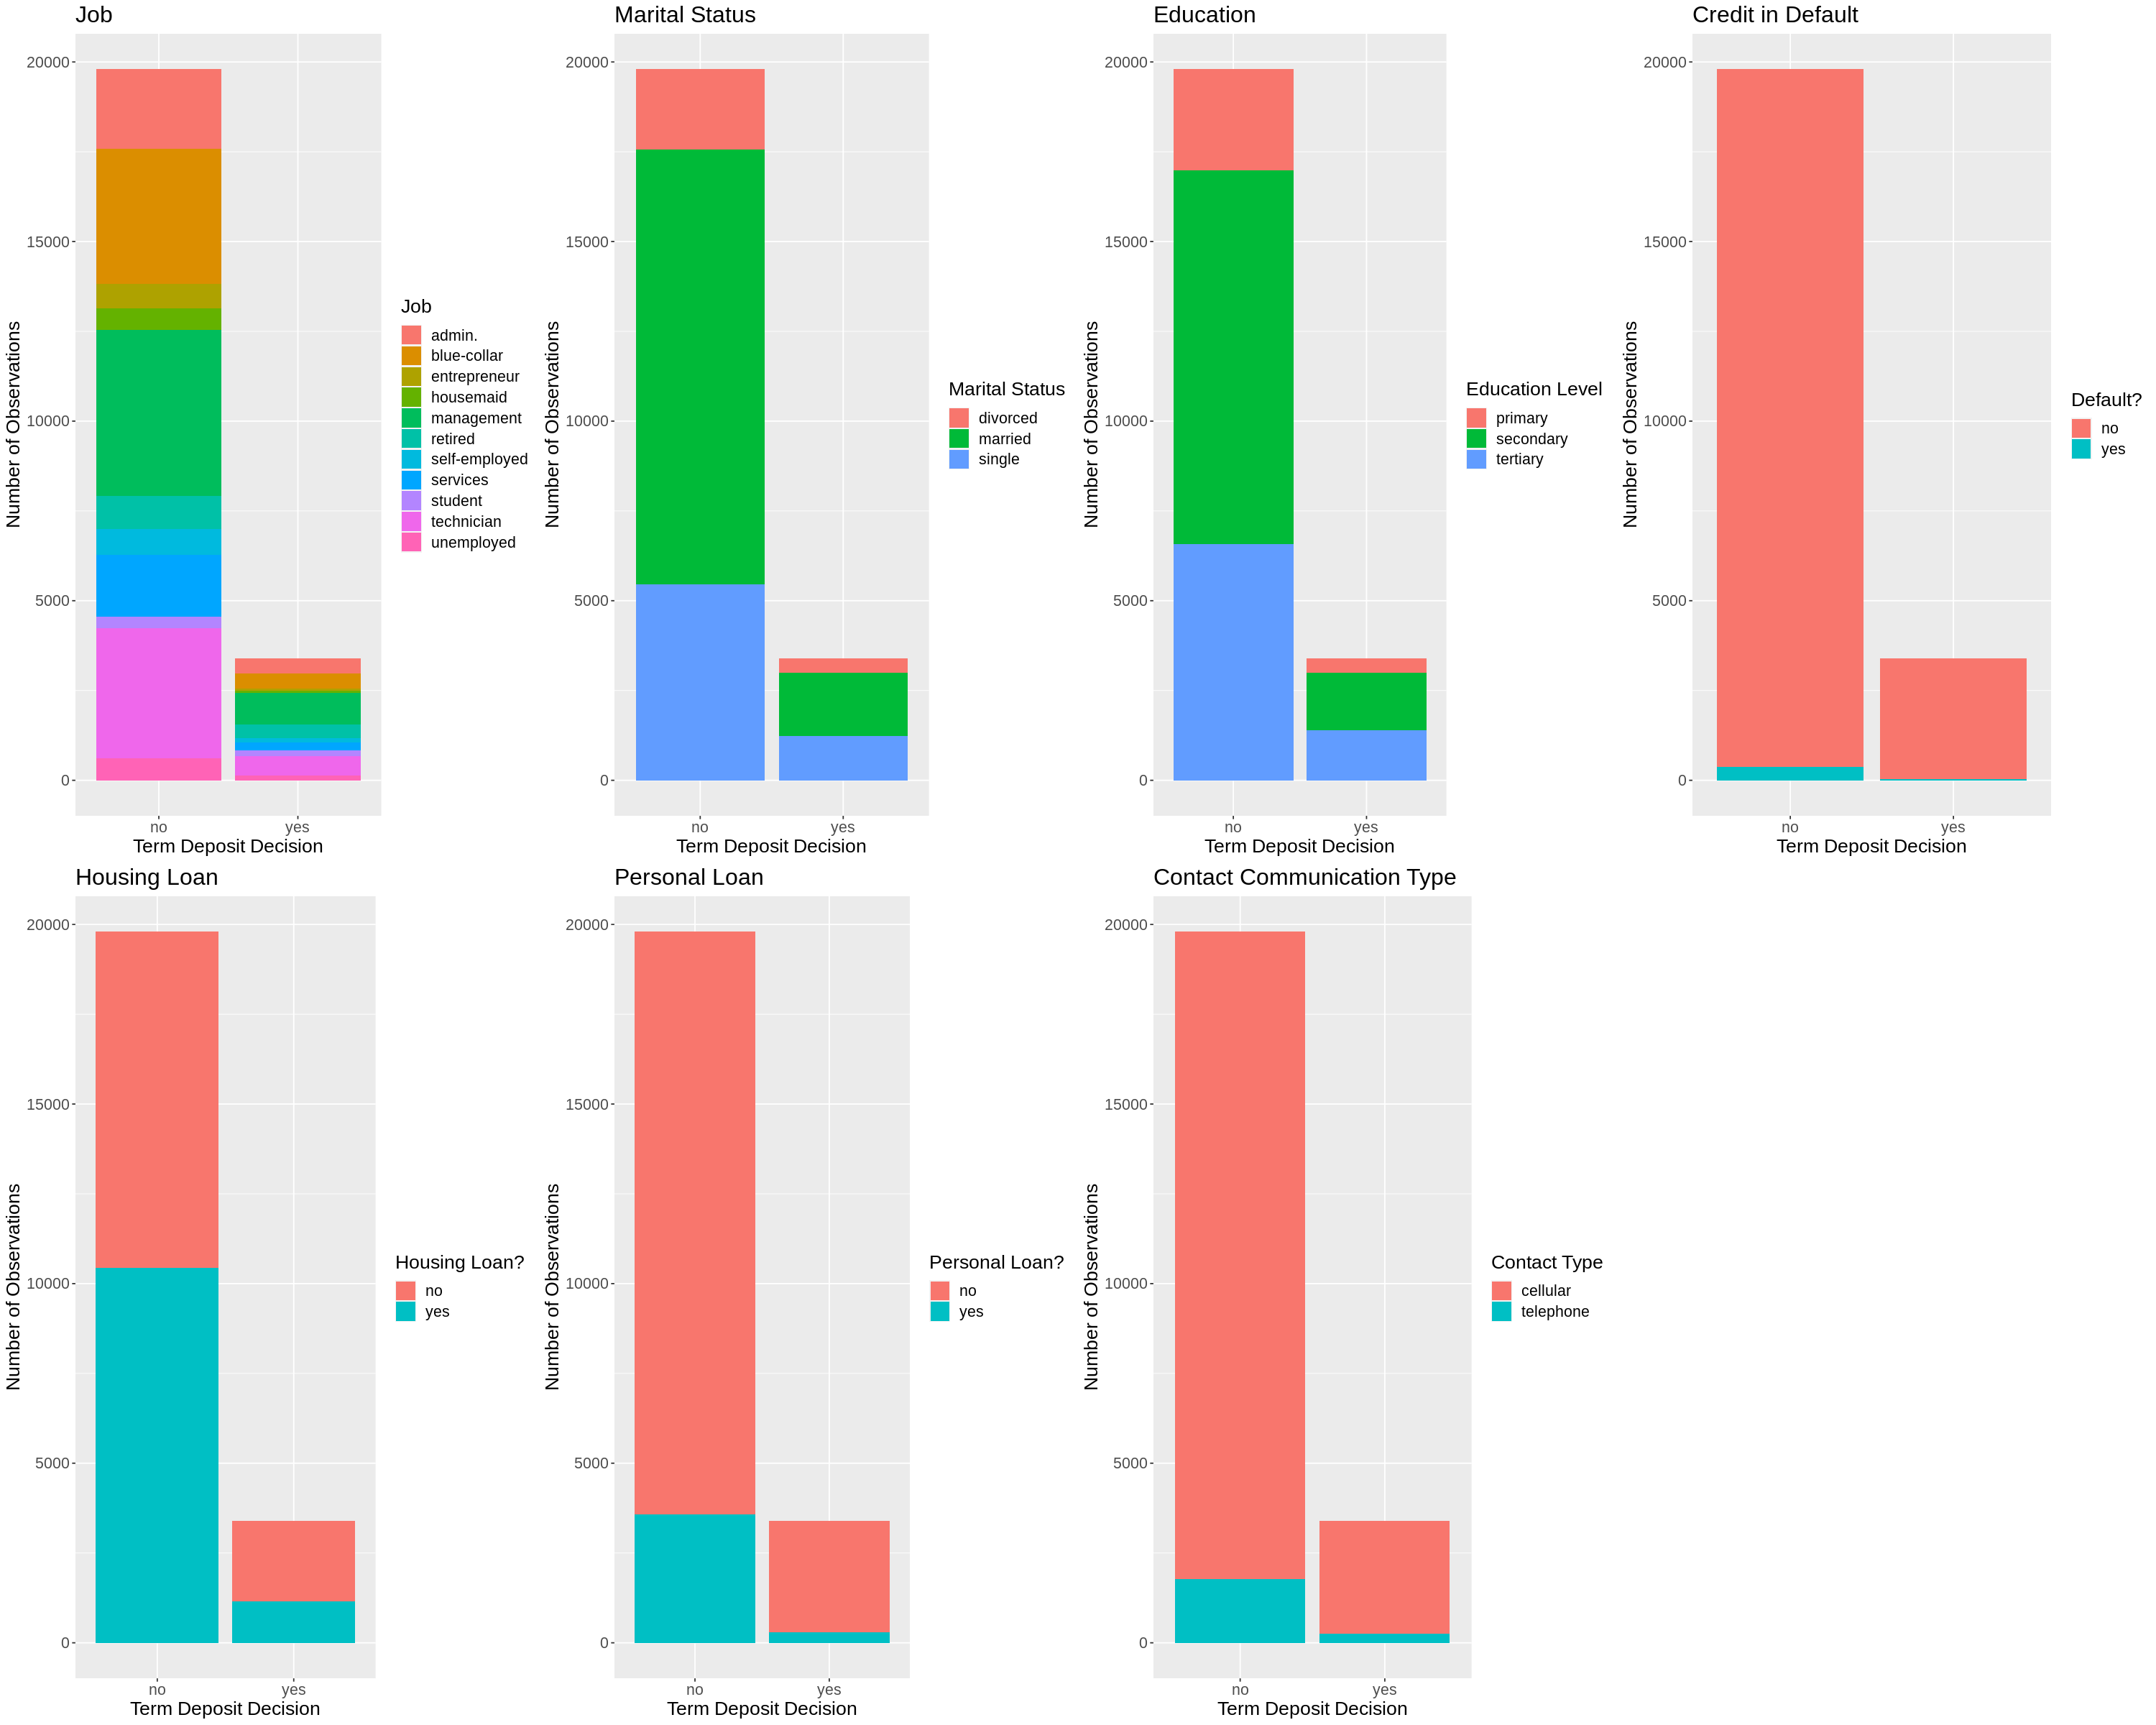

In [69]:
library(gridExtra)
options(repr.plot.width=25, repr.plot.height=20)

#Categorical Predictors

#Graph for Job
p_job <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = job)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Job") +
    ggtitle("Job")

#Graph Martial Status
p_marital <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = marital)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Marital Status") +
    ggtitle("Marital Status")

#Graph Education
p_education <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = education)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Education Level") +
    ggtitle("Education")

#Graph Default
p_default <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = default)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Default?") +
    ggtitle("Credit in Default")

#Graph Housing
p_housing <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = housing)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Housing Loan?") +
    ggtitle("Housing Loan")

#Graph Loan
p_loan <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = loan)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Personal Loan?") +
    ggtitle("Personal Loan")

#Graph Contact
p_contact <- ggplot(bank_train, aes(x = factor(y))) + 
    geom_bar(aes(fill = contact)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Contact Type") +
    ggtitle("Contact Communication Type")

grid.arrange(p_job, 
             p_marital, 
             p_education, 
             p_default, 
             p_housing, 
             p_loan, 
             p_contact, 
             nrow = 2)

Figure 1: Bar plots of each categorical variable, showing the distribution over their variables values.

From the plots above, we can observe that some of the variables are quite imbalanced. Specifically, default, loan, and contact are quite heavily skewed towards a single value ("no" for default and loan, "cellular" for contact). In addition, 'default' and 'contact' both have very similar distributions between the term deposit decisions, and thus these would not be good predictors for us to choose. This is because in order for the model to differentiate between the two term deposit decision values, the predictors values must differ as much as possible between the term deposit decision values. Marital and education also seem to have quite similar distributions between the term deposit decision values, so it's likely they would not be great predictors either. On the other hand, we can see that housing is very balanced between its two possible values, and its distribution is fairly different between the term deposit decision values, so it could possibly be a good predictor for us to choose, although some more analysis will be done to determine this. 

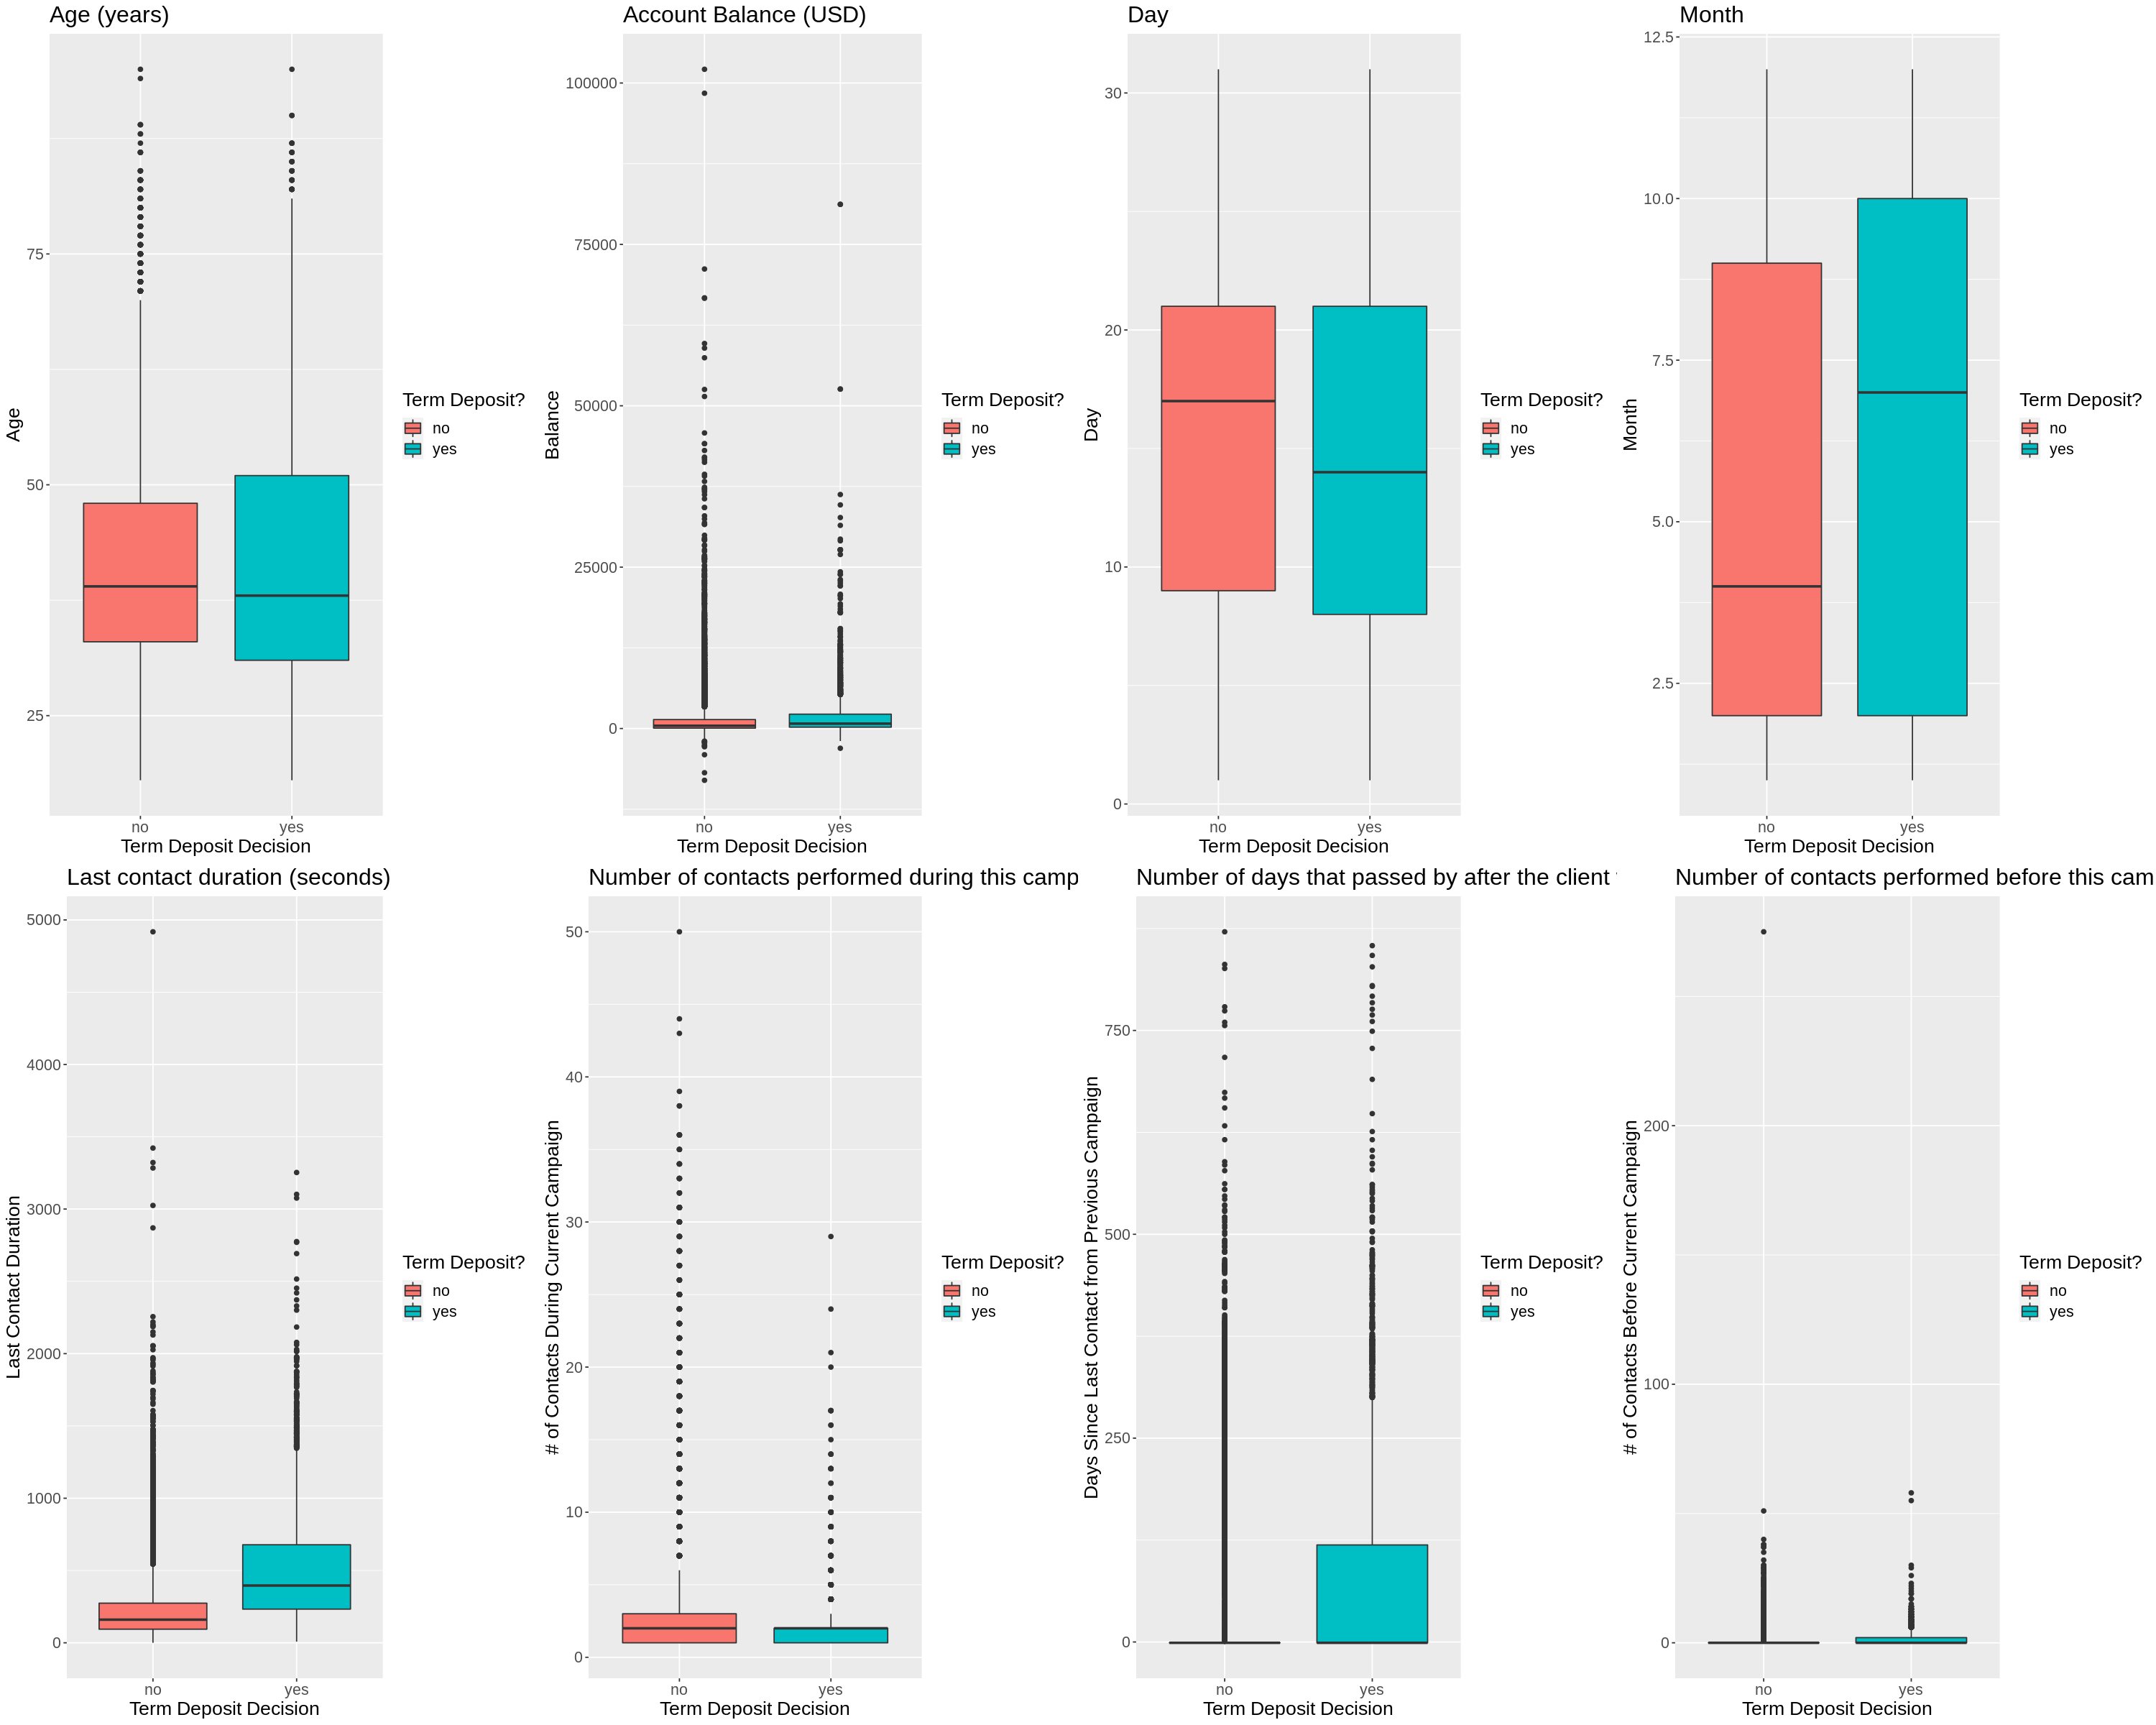

In [72]:
#Numerical Predictors

#Graph for Age
p_age <- ggplot(bank_data_nums, aes(factor(y), age)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Age", fill = "Term Deposit?") +
    ggtitle("Age (years)")

#Graph Balance
p_balance <- ggplot(bank_data_nums, aes(factor(y), balance)) + 
    geom_boxplot(aes(fill = factor(y)))+ 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Balance", fill = "Term Deposit?") +
    ggtitle("Account Balance (USD)")

#Graph Day
p_day <- ggplot(bank_data_nums, aes(factor(y), day)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Day", fill = "Term Deposit?") +
    ggtitle("Day")

#Graph Month
p_month <- ggplot(bank_data_nums, aes(factor(y), month)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Month", fill = "Term Deposit?") +
    ggtitle("Month")

#Graph Last contact duration
p_duration <- ggplot(bank_data_nums, aes(factor(y), duration)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Last Contact Duration", fill = "Term Deposit?") +
    ggtitle("Last contact duration (seconds)")

#Graph Campaign
p_campaign <- ggplot(bank_data_nums, aes(factor(y), campaign)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "# of Contacts During Current Campaign", fill = "Term Deposit?") +
    ggtitle("Number of contacts performed during this campaign and for this client")

#Graph Pdays
p_pdays <- ggplot(bank_data_nums, aes(factor(y), pdays)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Days Since Last Contact from Previous Campaign", fill = "Term Deposit?") +
    ggtitle("Number of days that passed by after the client was last contacted from a previous campaign")

#Graph Previous
p_previous <- ggplot(bank_data_nums, aes(factor(y), previous)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "# of Contacts Before Current Campaign", fill = "Term Deposit?") +
    ggtitle("Number of contacts performed before this campaign and for this client")

grid.arrange(p_age,
             p_balance,
             p_day,
             p_month,
             p_duration,
             p_campaign,
             p_pdays,
             p_previous,
             nrow = 2)

Figure 2: Boxplots of each numerical variable

The box plots above can give us some insight into the distributions of our numerical variables, although some of them are not very clear due to the large amount of outliers (e.g. balance, previous). Duration seems to be the predictor with the largest difference in distributions between the term deposit decision values, so it will likely be a good predictor for us to choose. It also seems like day and month have a a small difference between their distributions, however the date of contact does not seem to be very important for predicting the decision to subscribe to a term deposit, and could possibly be skewed based on when the campaigns were run in the past, thus they will not be included as predictors. From the remaining variables, it seems like age and campaign have a small difference between their distributions, but more analysis needs to be done before choosing the final predictors for the model

In [73]:
# Find the number of occurrences of each value of y to determine if there is a class imbalance
total_rows <- nrow(bank_data_filtered)
y_occurrence <- bank_data_filtered %>%
    group_by(y) %>%
    summarize(n = n(), n_percent = n()/total_rows)
y_occurrence


`summarise()` ungrouping output (override with `.groups` argument)



y,n,n_percent
<chr>,<int>,<dbl>
no,26394,0.8539813
yes,4513,0.1460187


Table 7: Distribution of Term Deposit Decision Values

From the table above, we can see that our dataset is quite imbalanced, with 85% of the observations being for customers who did not subscribe to a term deposit. As such, we must upscale our training data that will be used to train our model later on.

<h2>2d) Choosing and Defining the Predictors</h2>

In [74]:
#Still have error exists here in this section of code
library(GGally)
options(repr.plot.width=18, repr.plot.height=18)
bank_scaled_data <- recipe(y ~ ., data = bank_data_nums) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep() %>%
    bake(bank_data_nums)

predictor_means <- bank_scaled_data %>%
   group_by(y) %>%
   summarize(across(age:previous, mean))

predictor_means_diff <- predictor_means %>%
    select(age:previous) %>%
    tibble::rownames_to_column() %>%  
    pivot_longer(-rowname) %>% 
    pivot_wider(names_from=rowname, values_from=value) %>%
    rename(no_mean = 2, yes_mean = 3) %>%
    mutate(means_diff=abs(no_mean - yes_mean)) %>%
    arrange(desc(means_diff))

predictor_means_diff

`summarise()` ungrouping output (override with `.groups` argument)



name,no_mean,yes_mean,means_diff
<chr>,<dbl>,<dbl>,<dbl>
duration,-0.16348844,0.9561520,1.1196404
housing,0.05519222,-0.3227883,0.3779805
month,-0.04710326,0.2754805,0.3225838
campaign,0.03737813,-0.2186037,0.2559818
loan,0.03481345,-0.2036043,0.2384178
⋮,⋮,⋮,⋮
marital,0.020185943,-0.11805623,0.13824217
day,0.019131881,-0.11189162,0.13102350
age,-0.012875627,0.07530230,0.08817793


Table 8: Difference in predictor means grouped by term deposit decision values

From the table above, we can see that duration has the largest difference between its mean values out of all the variables by a significant margin. This means the average value of duration for customers that did subscribe to a term deposit is very different from the average value of duration for customers that didn't subscribe to a term deposit, which suggests that it would be a good predictor. Other than duration, it seems like the variables have somewhat similar differences between their mean values, so any predictor that isn't too low on the above table should be a decent predictor.

Based on the observations made so far, we can see that duration is an obvious choice for one of our predictors. Housing also seems to be a good choice, based on the bar plot of its distributions, as well as its large difference in mean values. Campaign will also be used as a predictor, due to its relatively large difference in mean values, as well as its small difference in its distributions observed from the box plots above. As the number of predictors shouldn't be too large, to limit complexity and computation needed, just one more predictor will be chosen. Balance will be used as the last predictor, because although it doesn't have the largest difference in its mean values, nor a significant difference in its distributions, it has the largest distribution of values out of all the predictors, which should help offset the possible inaccuracies introduced by using categorical variables such as housing as part of our predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



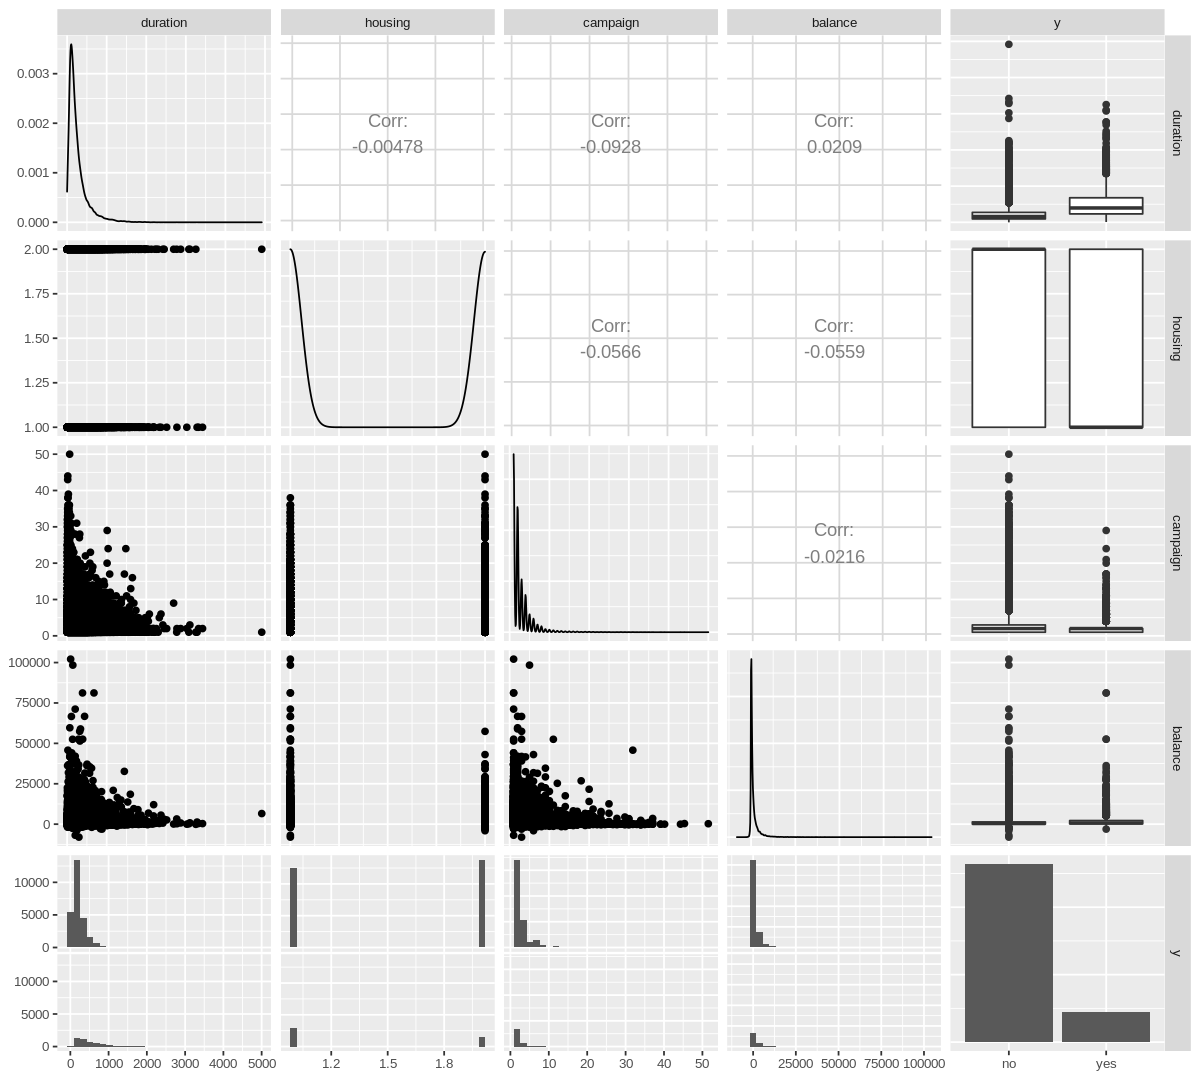

In [83]:
bank_train <- select(bank_data_nums, duration, housing, campaign, balance, y)
plot_pairs_bank_train <- bank_train %>%
  ggpairs +
  theme(text = element_text(size = 10))
plot_pairs_bank_train


Figure 3: Summary of the final predictors

In [87]:
# Creating the correlation matrix 
options(repr.plot.height = 9, repr.plot.width = 10)

corr_data <- cor(bank_data_nums, use = "pairwise.complete.obs")
# the second argument tells R to ignore specific column-row pairings that contain NA

corr_matrix <- corrplot(corr_data, method="color",  
                        type="upper", addCoef.col = "black")


ERROR: Error in cor(bank_data_nums, use = "pairwise.complete.obs"): 'x' must be numeric


<h2>3a) Methods</h2>


In [77]:
bank_upscaled_train <- recipe(y ~ ., data = bank_train) %>%
    step_upsample(y, over_ratio=1, skip = FALSE) %>%
    prep() %>%
    bake(bank_train)

total_rows <- nrow(bank_upscaled_train)
validate_balance <- bank_upscaled_train %>%
    group_by(y) %>%
    summarize(n = n(), n_percent = n()/total_rows)
validate_balance

`summarise()` ungrouping output (override with `.groups` argument)



y,n,n_percent
<fct>,<int>,<dbl>
no,19796,0.5
yes,19796,0.5


Table 9: Distribution of the term deposit decision values in the training set after upscaling

In [73]:
# Perform cross validation to determine the ideal # of neighbours

# Set the seed
set.seed(7134) 

# No need to use the entire dataset for this, 
# especially since cross validation would take too long on a datset so large
bank_sample <- rep_sample_n(bank_upscaled_train, 1000)

bank_k_recipe <- recipe(y ~ duration+housing+campaign+balance, data = bank_sample) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

bank_vfold <- vfold_cv(bank_sample, v = 5, strata = y)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_knn_results <- workflow() %>%
       add_recipe(bank_k_recipe) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = bank_vfold, grid = 20) %>%
       collect_metrics()

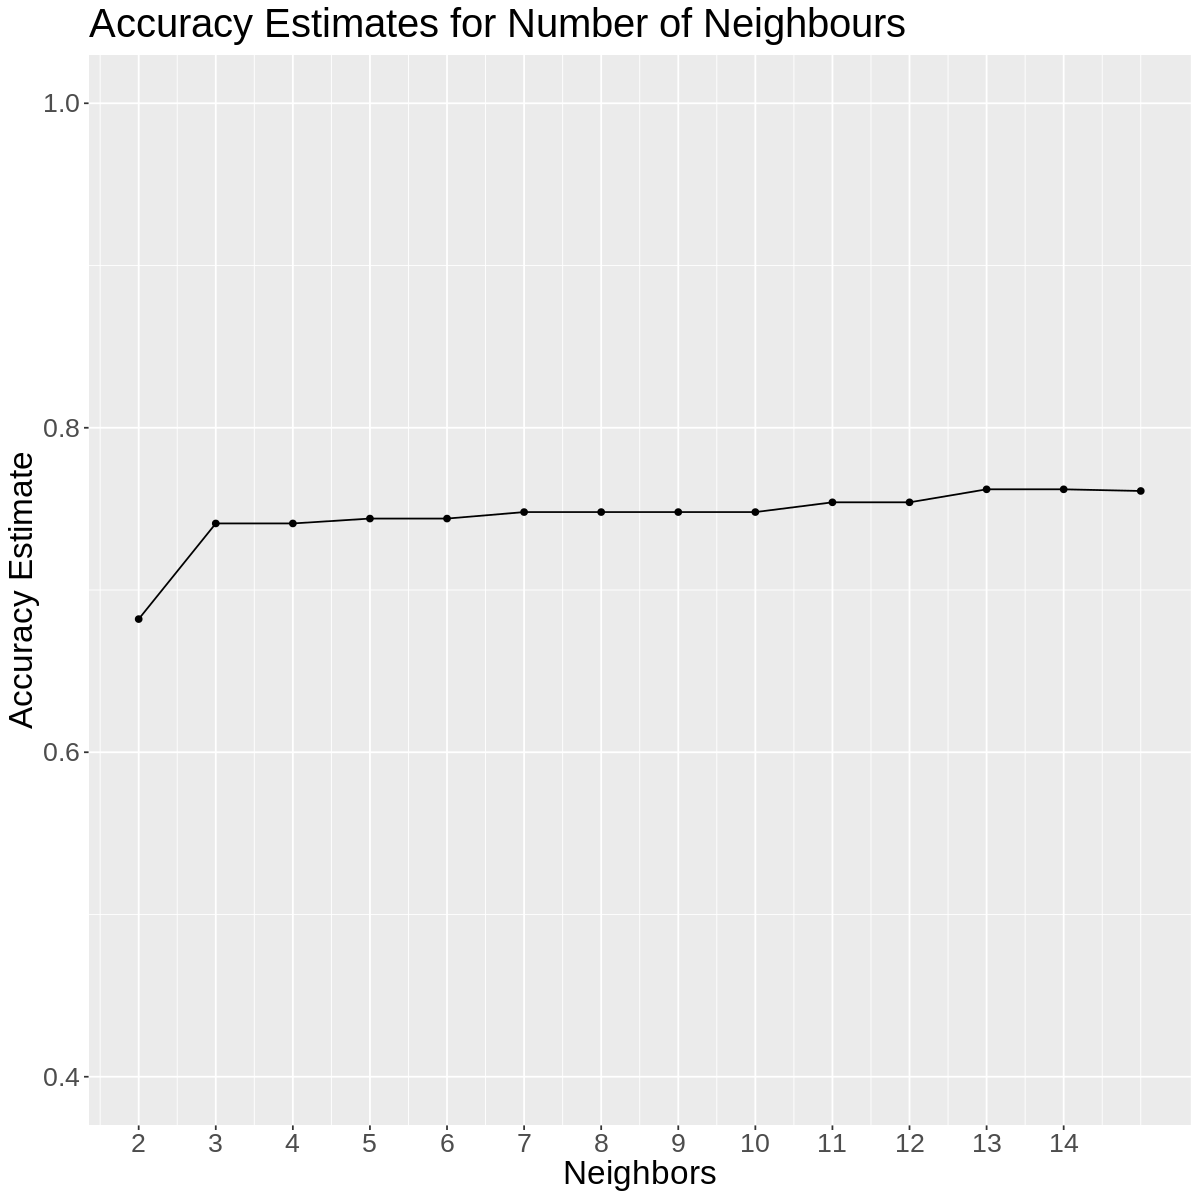

In [11]:
# Plot the accuracies of each k determined by cross validation
# to find the ideal value of k
options(repr.plot.width=10, repr.plot.height=10)

accuracies <- bank_knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Estimates for Number of Neighbours") +
       theme(text = element_text(size = 20)) +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

Figure 4: Accuracy estimates for various values for the number of neighbours to use in the model

**Note:** From the above plot, we can see that the accuracy increases greatly from k=2 to k=3, and from there increases slowly up until k=11. The increase in accuracy from k=3 to k=11 is not very large, while the increase in neighbours would greatly increase the amount of computation needed, therefore we will choose k=3.

In [75]:
bank_recipe <- recipe(y ~ duration+housing+campaign+balance, data = bank_upscaled_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

bank_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_fit <- workflow() %>%
        add_recipe(bank_recipe) %>%
        add_model(bank_spec) %>%
        fit(data = bank_upscaled_train)

In [76]:
bank_predictions <- predict(bank_fit , bank_test) %>%
       bind_cols(bank_test)
bank_predictions

.pred_class,duration,housing,campaign,balance,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,668,1,2,105,no
no,178,1,2,1146,no
no,273,1,3,187,no
no,125,1,2,93,no
yes,615,1,2,216,yes
⋮,⋮,⋮,⋮,⋮,⋮
yes,482,2,1,1224,yes
yes,414,1,2,3409,no
yes,401,1,2,133,yes


Table 10: Results of applying the classificationn model on the testing dataset

In [77]:
bank_metrics <- bank_predictions %>%
         metrics(truth = y, estimate = .pred_class)
bank_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7643024
kap,binary,0.2484307


Table 11: Final metrics of the classification model

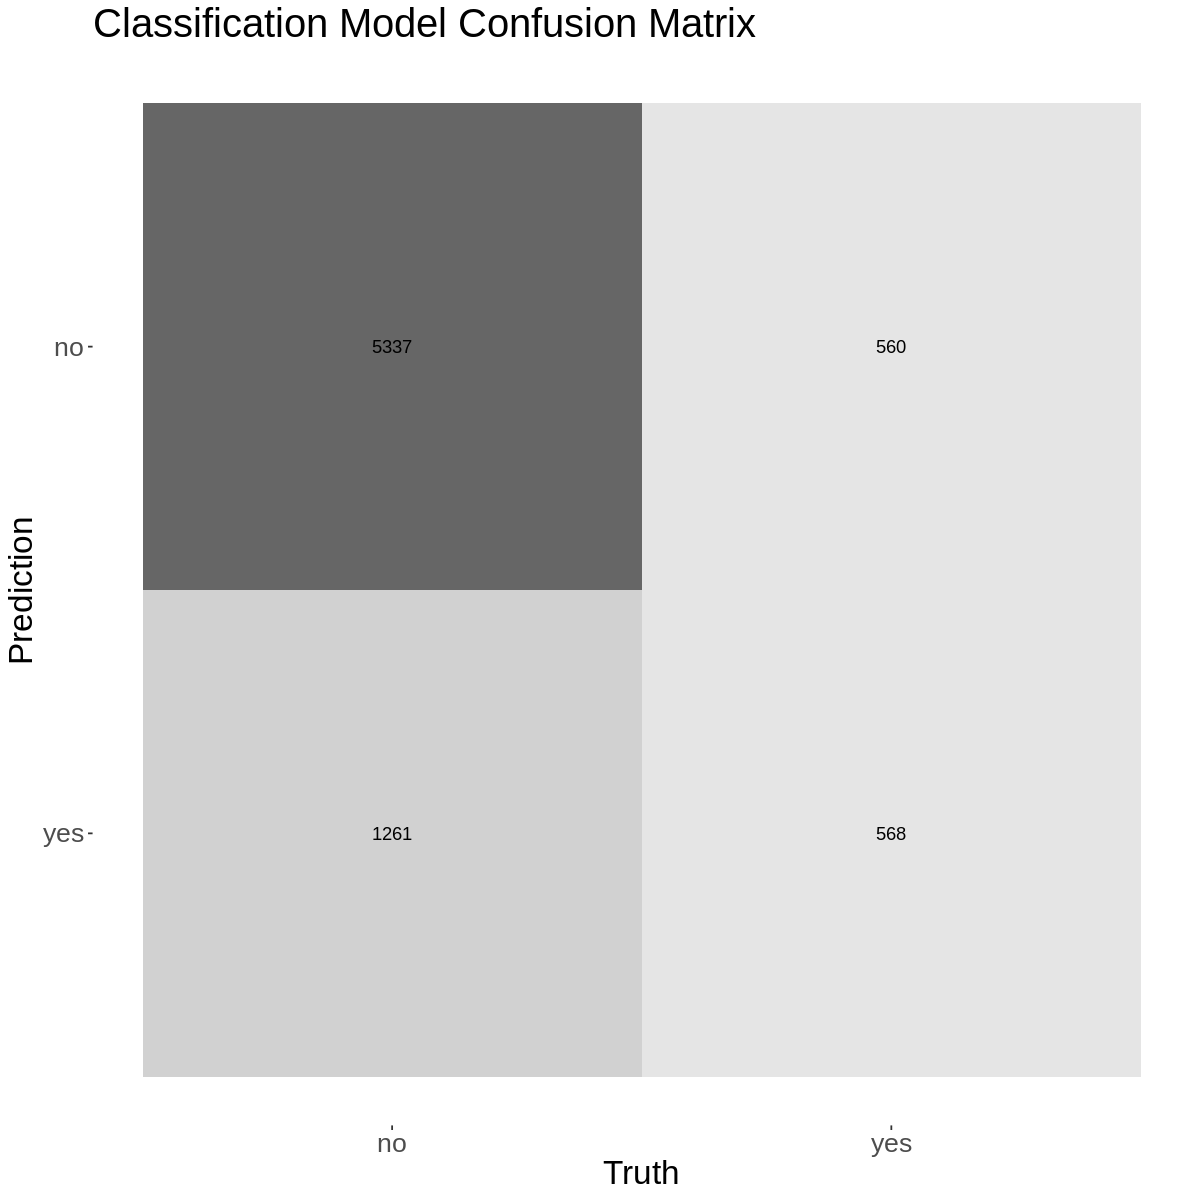

In [90]:
options(repr.plot.width=10, repr.plot.height=10)

bank_conf_mat <- bank_predictions %>% 
       conf_mat(truth = y, estimate = .pred_class)

autoplot(bank_conf_mat, 
         type = "heatmap", 
         label.size=20, 
         loadings.label.size=20) +
         theme(text = element_text(size=20)) +
         ggtitle("Classification Model Confusion Matrix")

Figure 5: Heatmap visualization of the classification model results

From the heatmap above, we can see that although it has a very high rate of predicting 'no' correctly, it was only able to predict 1261 'yes' data points correctly out of 1829 points. This would be an accuracy of ~69%, and while that isn't bad, it's a decent amount lower than the reported accuracy of 76% of our predictor.

In [91]:
duration_counts = bank_data_nums %>% 
     group_by(duration=cut(duration, breaks= seq(0, 1600, by = 100)) ) %>% 
     summarise(n= n()) %>%
     arrange(as.numeric(duration))
duration_counts

`summarise()` ungrouping output (override with `.groups` argument)



duration,n
<fct>,<int>
"(0,100]",7341
"(100,200]",9582
"(200,300]",5465
"(300,400]",3038
"(400,500]",1704
⋮,⋮
"(1.2e+03,1.3e+03]",95
"(1.3e+03,1.4e+03]",73
"(1.4e+03,1.5e+03]",65


Table 12: Distribution of duration

In [92]:
housing_counts <- bank_data_nums %>%
    group_by(housing, y) %>%
    summarize(n = n()) %>%
    arrange(desc(n))
housing_counts

`summarise()` regrouping output by 'housing' (override with `.groups` argument)



housing,y,n
<dbl>,<fct>,<int>
2,no,13831
1,no,12563
1,yes,3001
2,yes,1512


Table 13: Distribution of housing

In [93]:
campaign_counts <- bank_data_nums %>%
    group_by(campaign, y) %>%
    summarize(n = n()) %>%
    arrange(desc(n))
campaign_counts

`summarise()` regrouping output by 'campaign' (override with `.groups` argument)



campaign,y,n
<dbl>,<fct>,<int>
1,no,9611
2,no,7467
3,no,3113
4,no,2272
1,yes,2218
⋮,⋮,⋮
29,yes,1
39,no,1
43,no,1


Table 14: Distribution of campaign

In [94]:
balance_counts <- bank_data_nums %>%
    group_by(balance=cut(balance, breaks= seq(-8019, 102127, by = 5000)) ) %>% 
    summarize(n = n()) %>%
    arrange(desc(n))
balance_counts

`summarise()` ungrouping output (override with `.groups` argument)



balance,n
<fct>,<int>
"(-3.02e+03,1.98e+03]",24791
"(1.98e+03,6.98e+03]",4930
"(6.98e+03,1.2e+04]",758
"(1.2e+04,1.7e+04]",226
"(1.7e+04,2.2e+04]",84
⋮,⋮
"(7.7e+04,8.2e+04]",2
NA,2
"(4.7e+04,5.2e+04]",1


Table 15: Distribution of balance

One weakness that we can identify from these tables is that our data is fairly imbalanced, with most of our data being for people who did not subscribe to a term deposit (i.e. the 'y' value was 'no'). This means that our predictor may not be as accurate as we think, since if our predictor was actually predicting 'no' excessively, our test data would still return a high accuracy.  In addition, some of our predictors are imbalanced as well, such as duration being centered around values less than 500, and balance being mostly within \$3000 of \$0. Although our classifier has high accuracy for our current data, it may not be as accurate for data with values that are significantly different than our current data. However, this is not a large concern, as these outliers will not be too common, and we are more interested in the overall accuracy of the predictor 

<h2> Methods & Results </h2>

To predict will the client subscribe to a term deposit or not, we first download the dataset from the University Institue of Lisbon. However, the 20 predictors in the original dataset are too complex for the program. It will cause the KNN classification progress to become very slow and unreliable. In addition, KNN classification does not work well with a large number of predictors. Hence, after conducting thorough researches, we decide to filter out the number of predictors by conducting a visual comparsion and numerical relationship anlysis. We investigate on the data relationship between the predictors and the outcome by generating graphs and summing up the results on the numerical anlysis. At last, we have choosen the <b>four</b> most significant variables, "duration (last contact duration in seconds)", "housing (clients have housing loans or not)", "campaign(number of contacts performed during this campaign and for this client)", and "balance(customer's account balance)" as our KNN predictors. We filter out the valid data in the spreadsheet and come out with 41188 observations. We scale the data to make sure the dataset has been standardized. Due to the large sample size, we believe it is reasonable and logical to spilt 75% of the dataset into the training set and 25% into the testing set. We also reassure that the issue of class imbalance is solved and does not exist in this stage to prevent any upsampling and downsampling issues. 

Afterwards, we conduct a cross-validation analysis by creating nearest_neighbors model specification, with neighbours equals to tune(). Then, we add a recipe and model specification to the workflow function, and use the tune_grid function on the train/validation splits to estimate the classifier accuracy for a range of K values. At last, we will conclude the results in a visual presentation (graph) for easier observation. 

After picking the optimum K parameter from the graph, we can proceed to the KNN classification prediction step. We create a new model specification for the best parameter value and retrain the classifier using the fit function. At last, we evaluate the estimated accuracy of the classifier on the test set using the predict function. For better comparison, we will use the ggpairs function to generate a matrix of plots, showing all the graphs and correlation coefficients of the variables in our analyses. At last, we can conclude the accuracy of our KNN classification model and predict how many bank clients subscribe to term deposits or not, also identifying which of the variables have the highest correlation with the outcome.  (365 Words)



<h2> Discussion </h2>
    
    
**Summarize what you found and Discuss whether this is what you expected to find?**


Our results show that a multivariate KNN classifier using K=3 neighbours predicts outcomes in our banking data set with the highest accuracy level (estimated 0.75). Increases in k beyond this level delivered decreasing marginal improvements in accuracy. To reiterate, the predictors used in our classifier are “duration”, “housing”, and “campaign” based on their large differences in mean values. The fourth predictor “balance” is used to offset inaccuracies caused by using categorical variables in our classification. 

Furthermore, our tables displaying counts by predictor variable highlight an imbalance in our data, with most of the points falling under the class of “no” under the “y” value (i.e. people who did not subscribe to a term deposit). This is also shown in our confusion matrix, which illustrates a similar imbalance carried over into our predictor, resulting in a high classification rate for “no” data points, but only ~69% for “yes” points. 

Additionally, with regards to the confusion matrix we found that roughly 16% of all the "yes" decisions that were predicted were in realtiy a "no" answer and 7% of all "no" answers that were predicted were acutally a "yes". This is troublesome to see espically for the "yes" answer when in reality it is a "no" as trying to provide a customer with a servicve that they do not want and have said no to is bad business practice and will hurt the reputation of the bank.

These findings run somewhat contrary to our general understanding regarding the popularity of term deposits. The frequency of term deposits made by clients vary depending on the terms of such an account (i.e. length of time during which a customer agrees not to withdraw funds in return for a higher rate of interest paid on their account). Generally, term deposits are very safe investments and generally attract conversative, low risk investors (Chen, 2020). Thus, while they may not be considered the most popular investment option, term deposit accounts are still viable and stable options for groups such as retirees, so our finding that a disproportionate number of clients decided not to open an account presents a slight discrepancy. An explanation for this could be a result of the time frame during which the original data was recorded. The Portugese banking institution ran this marketing campaign from May 2008 to November 2010, right in the heat of the US Financial Crisis. There is a high chance that the effects of the crisis spilled over into investors in Portugal and deterred many from trusting in banking institutions, let alone opening new accounts with such maturity dates (Chen et al., 2018). 


**Discussion what impact could such findings have**

In any case, we believe that our findings from this research provide insights to banking institutions worldwide as to how to effectively strategize marketing efforts to gain more clientele and incentivize more participation in bank term deposits. Our analysis to determine which variables are the most relevant in determining the outcome of a client’s behaviour alone gives a great deal of information to banks as to how they could target marketing campaigns or promotions. For instance, our boxplots graphing the relationship between each variable and its class show that “duration” has a large difference in density of “yes” and “no”. This suggests the “duration” variable is a viable indicator for customer success, so banks could implement programs that reward salespeople based on the amount of time they interact with clients (since higher duration can lead to more success in getting a customer a term deposit). 

**Discussion  what future questions could this lead to**

Further research on other variables that affect the outcome of a client’s decision could be conducted to gather a more holistic view of a prospective customer’s behaviour. For instance, banks could factor in data from international banks and institutions to better predict trends that come from investors overseas. Data on characteristics like exchange rates and domestic interest rates could provide insights on how an individual from France may view Portugese investment opportunities as compared to someone from the United States. Questions related to this could be 
Do the nationalities of investors and global market trends have an influence on the proportion of term deposit accounts opened at a Portugese banking institution?
How do interest rates and exchange rates impact the success of a domestic bank?


<h2> References </h2>

1) Chen, James. “Term Deposit Definition.” Investopedia, Investopedia, 16 Sept. 2020, www.investopedia.com/terms/t/termdeposit.asp.<br />
<br />
2) Chen, Wenjie, et al. “Lasting Effects: The Global Economic Recovery 10 Years After the Crisis.” IMF Blog, International Monetary Fund, 13 Mar. 2019, blogs.imf.org/2018/10/03/lasting-effects-the-global-economic-recovery-10-years-after-the-crisis/#:~:text=In the year following the,all countries in the world.&text=Moreover, there are also signs,well as on income inequality.<br />